In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Importing the Libraries**

In [25]:
import os
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

**Loading the Data Files**

In [3]:
BigGAN="/content/drive/MyDrive/Deep Fake/Dataset/GAN/biggan"
GauGAN="/content/drive/MyDrive/Deep Fake/Dataset/GAN/gaugan"
StarGAN="/content/drive/MyDrive/Deep Fake/Dataset/GAN/stargan"
StyleGAN="/content/drive/MyDrive/Deep Fake/Dataset/GAN/stylegan"
BigGAN_lis=os.listdir(BigGAN)
GauGAN_lis=os.listdir(GauGAN)
StarGAN_lis=os.listdir(StarGAN)
StyleGAN_lis=os.listdir(StyleGAN)

In [4]:
print(len(BigGAN_lis))
print(len(GauGAN_lis))
print(len(StarGAN_lis))
print(len(StyleGAN_lis))

1200
1170
1131
1305


**Creating the Dataset**

In [5]:
BigGAN_dataset=[]
GauGAN_dataset=[]
StarGAN_dataset=[]
StyleGAN_dataset=[]

for i in range(len(BigGAN_lis)):
   BigGAN_lis[i]=BigGAN+'/'+BigGAN_lis[i]
   BigGAN_dataset.append([BigGAN_lis[i],1])

for i in range(len(GauGAN_lis)):
   GauGAN_lis[i]=GauGAN+'/'+GauGAN_lis[i]
   GauGAN_dataset.append([GauGAN_lis[i],2])

for i in range(len(StarGAN_lis)):
   StarGAN_lis[i]=StarGAN+'/'+StarGAN_lis[i]
   StarGAN_dataset.append([StarGAN_lis[i],3])

for i in range(len(StyleGAN_lis)):
   StyleGAN_lis[i]=StyleGAN+'/'+StyleGAN_lis[i]
   StyleGAN_dataset.append([StyleGAN_lis[i],4])

Shuffling the Dataset

In [6]:
random.shuffle(BigGAN_dataset)
random.shuffle(GauGAN_dataset)
random.shuffle(StarGAN_dataset)
random.shuffle(StyleGAN_dataset)

In [7]:
dataset = GauGAN_dataset[:500] + StyleGAN_dataset[:500] + BigGAN_dataset[:500] + StarGAN_dataset[:500]

In [8]:
random.shuffle(dataset)

In [9]:
print(dataset[2])

['/content/drive/MyDrive/Deep Fake/Dataset/GAN/stargan/0191.png', 3]


**Creating the Training, Validation and Testing Dataset**

In [10]:
X_train=[]
y_train=[]
for x in dataset:
    X_train.append(x[0])
    y_train.append(x[1])

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

**Preprocessing the Data**

In [12]:
def resize_image_3d(image_array, target_shape=(224, 224, 3)):
    if len(image_array.shape) != 3 or image_array.shape[2] != target_shape[2]:
        raise ValueError(f"Input array must have shape (height, width, {target_shape[2]})")

    resized_image = np.array(Image.fromarray(image_array).resize((target_shape[1], target_shape[0])))

    return resized_image


In [13]:
Im_train = []
Y_train = []

for i in range(len(X_train)):
    img = Image.open(X_train[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_train.append(im_array)
        Y_train.append(y_train[i])

Im_valid = []
Y_val = []

for i in range(len(X_val)):
    img = Image.open(X_val[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_valid.append(im_array)
        Y_val.append(y_val[i])


Loading the base model: **Resnet50**

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 1s 0us/step


Freezing the layers of base model

In [15]:
for layer in base_model.layers:
    layer.trainable = False

Definingn the parameters and hyperparameters

In [17]:
num_classes = 4
batch_size = 30
epochs = 10
learning_rate = 0.0005

Adding the layers

In [18]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, activation='softmax'))

Compiling the Model

In [19]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
Im_train = np.array(Im_train)
Y_train = np.array(Y_train)
Im_valid = np.array(Im_valid)
Y_val = np.array(Y_val)

**Encoding the output using One Hot Encoding**

In [21]:
encoder = OneHotEncoder(sparse=False)
Y_train_encoded = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_val_encoded = encoder.transform(Y_val.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
print("Encoder categories:", encoder.categories_)
label=np.array([1,2,3,4])
print(encoder.transform(label.reshape(-1, 1)))

Encoder categories: [array([1, 2, 3, 4])]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


**Training the Model**

In [23]:
history = model.fit(
    Im_train, Y_train_encoded,
    epochs=epochs,
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 1/10
50/50 [==============================] - 445s 9s/step - loss: 0.7531 - accuracy: 0.6925 - val_loss: 0.4583 - val_accuracy: 0.8050
Epoch 2/10
50/50 [==============================] - 381s 8s/step - loss: 0.3303 - accuracy: 0.8775 - val_loss: 0.3583 - val_accuracy: 0.8500
Epoch 3/10
50/50 [==============================] - 428s 9s/step - loss: 0.2523 - accuracy: 0.9131 - val_loss: 0.3065 - val_accuracy: 0.8750
Epoch 4/10
50/50 [==============================] - 434s 9s/step - loss: 0.2128 - accuracy: 0.9294 - val_loss: 0.2873 - val_accuracy: 0.8650
Epoch 5/10
50/50 [==============================] - 380s 8s/step - loss: 0.1895 - accuracy: 0.9350 - val_loss: 0.2705 - val_accuracy: 0.8850
Epoch 6/10
50/50 [==============================] - 389s 8s/step - loss: 0.1694 - accuracy: 0.9438 - val_loss: 0.2578 - val_accuracy: 0.8850
Epoch 7/10
50/50 [==============================] - 420s 8s/step - loss: 0.1549 - accuracy: 0.9513 - val_loss: 0.2485 - val_accuracy: 0.9000
Epoch 8/10
50

Learning Curves

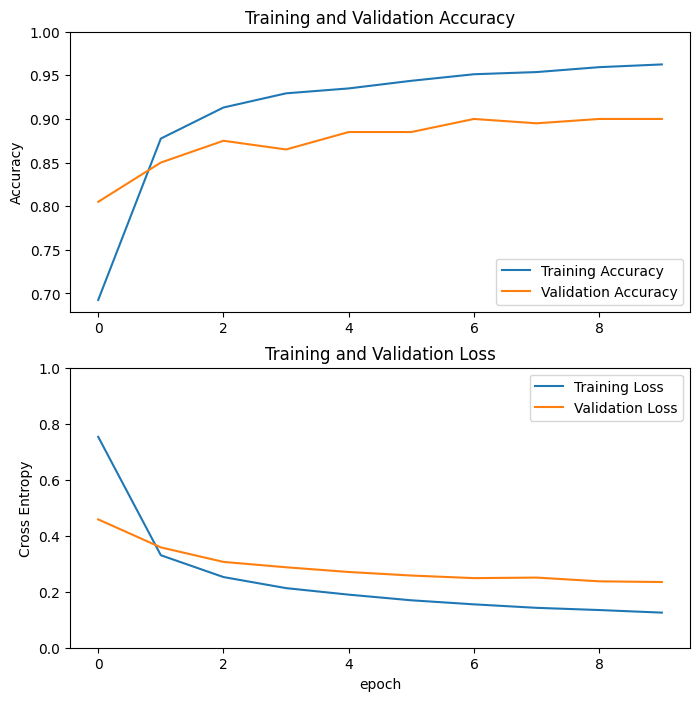

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning the Model**

Unfreezing the last layers

In [27]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:40]:
  layer.trainable = False

In [28]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Traing the model

In [29]:
history_fine = model.fit(
    Im_train, Y_train_encoded,
    epochs=15,
    initial_epoch=history.epoch[-1],
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 10/15
50/50 [==============================] - 400s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 11/15
50/50 [==============================] - 381s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 12/15
50/50 [==============================] - 421s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 13/15
50/50 [==============================] - 382s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 14/15
50/50 [==============================] - 419s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000
Epoch 15/15
50/50 [==============================] - 378s 8s/step - loss: 0.1173 - accuracy: 0.9675 - val_loss: 0.2346 - val_accuracy: 0.9000


In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

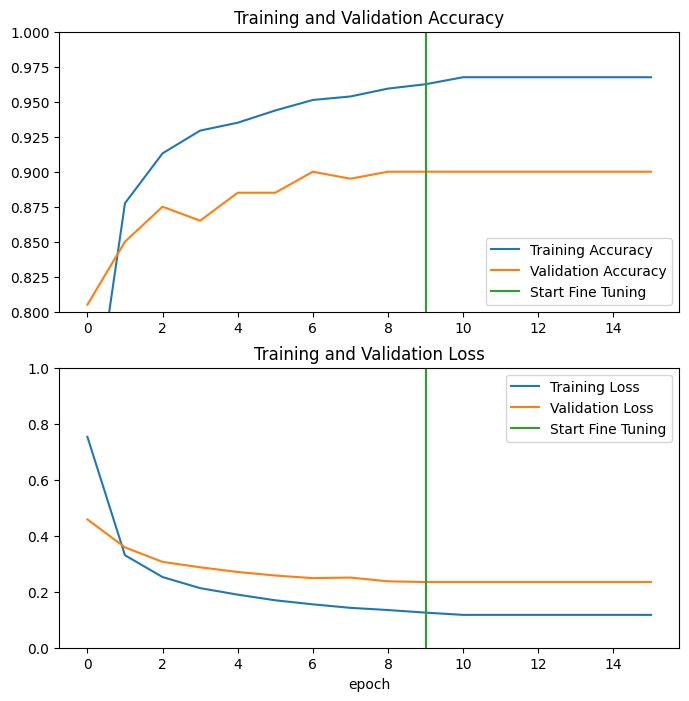

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([9,9],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([9,9],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
fine_tuned_model_path = '/content/drive/MyDrive/Deep Fake/fine_tuned_level3GAN.h5'
model.save(fine_tuned_model_path)

**Testing the Model**

In [33]:
Im_test = []
Y_test = []

for i in range(len(X_test)):
    img = Image.open(X_test[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_test.append(im_array)
        Y_test.append(y_test[i])

In [34]:
Im_test = np.array(Im_test)
Y_test = np.array(Y_test)

In [35]:
Y_test_encoded = encoder.transform(Y_test.reshape(-1, 1))

Evaluating the Model

In [36]:
evaluation = model.evaluate(Im_test, Y_test_encoded)

7/7 [==============================] - 45s 6s/step - loss: 0.1900 - accuracy: 0.9350


In [37]:
accuracy = evaluation[1]

print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9350000023841858
